In [8]:
import numpy as np
import random
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20, 10)

In [9]:
def gradient_descent(gradient_func, start_point, iterations, eps):
    '''
    Метод градиентного спуска
    :param gradient_func: функция градиента
    :param step_func: функция изменения шага
    :param start_point: начальное приближение
    :param iterations: число итераций до остановки
    :param eps: максимальное расстояние между точками для остановки
    '''
    current_point = start_point
    current_gradient = np.array([0.0] * len(start_point))
    for it in range(iterations):
        next_gradient = gradient_func(current_point, current_gradient)
        next_point = current_point + next_gradient

        distance = np.linalg.norm(current_point - next_point)
        if distance < eps:
            return current_point, it

        current_point = next_point
        current_gradient = next_gradient

    return current_point, iterations

In [10]:
class MeanSquaredError:
    def function(self, regression, points, state):
        sum_square_error = 0.0
        for p in points:
            sum_square_error += (p[1] - regression.function(state, p[0])) ** 2
        return sum_square_error / len(points)

    def gradient(self, regression, points, state):
        sum_square_error = np.array([0.0] * len(state + 1))
        for p in points:
            sum_square_error -= 2 * (p[1] - regression.function(state, p[0])) * regression.gradient(state, p[0])
        return sum_square_error / len(points)

In [11]:
def standart_gradient(regression, points, n, error_func, step):
    def next_gradient(current_point, current_gradient):
        return - step * error_func.gradient(regression, random.sample(points, n), current_point)
    return next_gradient

def momentum_gradient(regression, points, n, error_func, mu, step):
    def next_gradient(current_point, current_gradient):
        return mu * current_gradient - step * error_func.gradient(regression, random.sample(points, n), current_point)
    return next_gradient

def nesterov_gradient(regression, points, n, error_func, mu, step):
    def next_gradient(current_point, current_gradient):
        return mu * current_gradient - step * error_func.gradient(regression, random.sample(points, n), current_point + mu * current_gradient)
    return next_gradient

In [12]:
class LinearRegression:
    def function(self, state, point):
        res = state[0]
        for i in range(len(point)):
            res += state[i + 1] * point[i]
        return res

    def gradient(self, state, point):
        return np.concatenate(([1.0], point))

In [13]:
number_of_points = 100
number_of_dimensions = 50
points = []
for i in range(number_of_points):
    sum = 1
    point = []
    for j in range(number_of_dimensions):
        x = random.uniform(-10, 10)
        point.append(x)
        sum += (2 + j) * x
    points.append((point, sum + random.uniform(0, 0)))

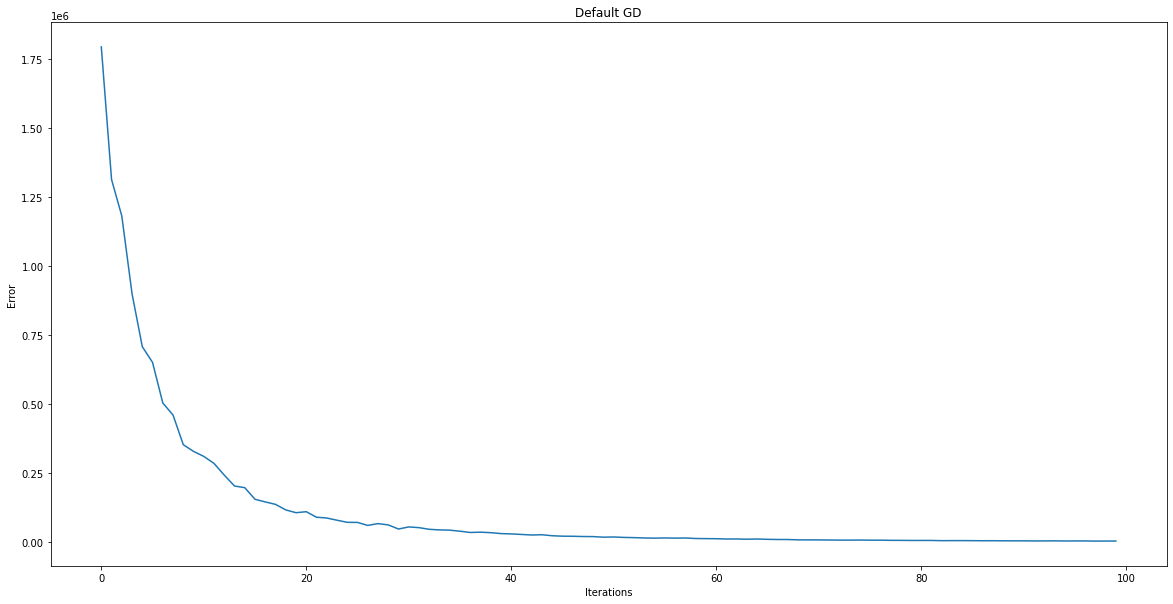

In [18]:
regression = LinearRegression()
error_func = MeanSquaredError()
step = 1e-3
eps = 1e-5

iterations = range(100)
errors = []

for it in iterations:
    x = gradient_descent(
        gradient_func=standart_gradient(
            regression=regression,
            points=points,
            n=number_of_dimensions,
            error_func=error_func,
            step=step
        ),
        start_point=np.array([0.0] * (len(points[0][0]) + 1)), 
        iterations=it,
        eps=eps
    )[0]
    errors.append(error_func.function(regression, points, x))

plt.title('Default GD')
plt.xlabel('Iterations')
plt.ylabel('Error')
plt.plot(iterations, errors)

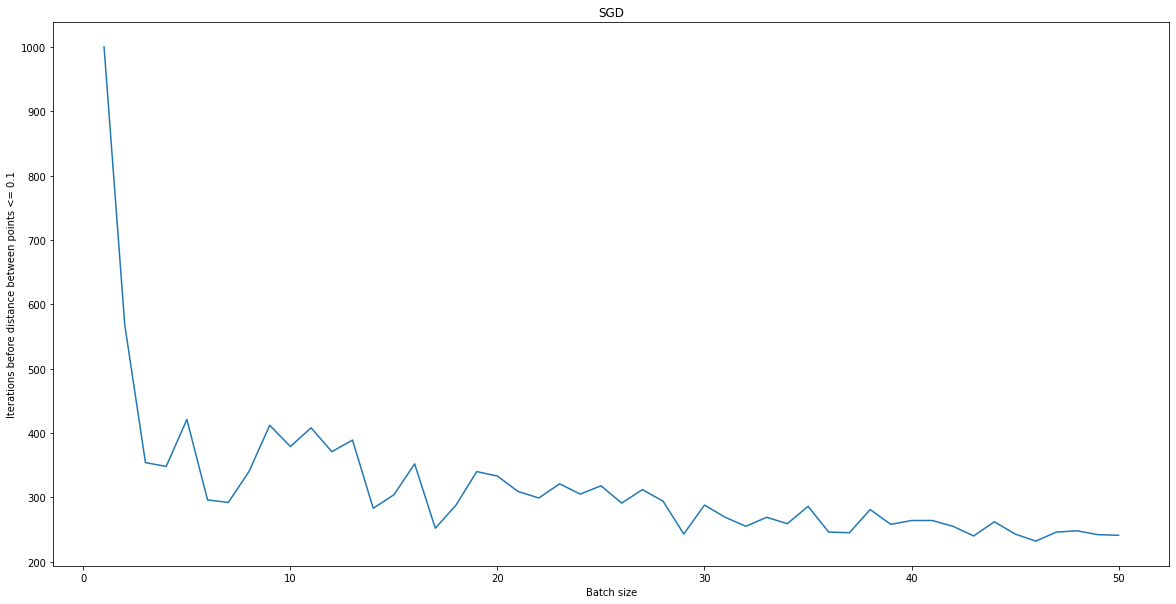

In [19]:
regression = LinearRegression()
error_func = MeanSquaredError()
step = 1e-3
eps = 1e-1

batch_sizes = range(1, number_of_dimensions + 1)
iterations = []

for batch_size in batch_sizes:
    it = gradient_descent(
        gradient_func=standart_gradient(
            regression=regression,
            points=points,
            n=batch_size,
            error_func=error_func,
            step=step
        ),
        start_point=np.array([0.0] * (len(points[0][0]) + 1)), 
        iterations=1000,
        eps=eps
    )[1]
    iterations.append(it)

plt.title('SGD')
plt.xlabel('Batch size')
plt.ylabel(f'Iterations before distance between points <= {eps}')
plt.plot(batch_sizes, iterations)

In [16]:
print(gradient_descent(
    gradient_func=standart_gradient(
        regression=LinearRegression(),
        points=points,
        n=1,
        error_func=MeanSquaredError(),
        step=0.01
    ),
    start_point=np.array([0.0] * (len(points[0][0]) + 1)), 
    iterations=1000,
    eps=1e-5
))

print(gradient_descent(
    gradient_func=momentum_gradient(
        regression=LinearRegression(),
        points=points,
        n=3,
        error_func=MeanSquaredError(),
        step=0.01,
        mu=0.9
    ),
    start_point=np.array([0.0] * (len(points[0][0]) + 1)), 
    iterations=1000,
    eps=1e-5
))

print(gradient_descent(
    gradient_func=nesterov_gradient(
        regression=LinearRegression(),
        points=points,
        n=3,
        error_func=MeanSquaredError(),
        step=0.01,
        mu=0.9
    ),
    start_point=np.array([0.0] * (len(points[0][0]) + 1)), 
    iterations=1000,
    eps=1e-5
))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in multiply
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in subtract
  # This is added back by InteractiveShellApp.init_path()


(array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]), 1000)
(array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]), 1000)
(array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]), 1000)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in subtract
  # This is added back by InteractiveShellApp.init_path()
